# Coral Classification for Survey and Research
A convolutional neural network is trained for classifying healthy and bleahed corals. This can be deployed on a on-board computer of autonomous/ controlled submersible survey vehicle.

Importing necessary libraries and modules:

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

Checking number of GPUs in the system:

In [2]:
num_gpus = tf.config.experimental.list_physical_devices('GPU')
len(num_gpus)

0

Therefore, we would not use any GPU in training.

Visualizing a sample image from the class 'healthy_corals':

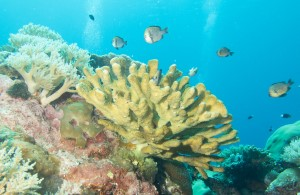

In [3]:
sample_path = r"./train/healthy_corals/" + random.choice(os.listdir(r"./train/healthy_corals/"))
image = np.expand_dims(plt.imread(sample_path),0)
display(Image.open(sample_path))

Define paths of train, test and validation data:

In [4]:
train_path = './train'
valid_path = './validation'
test_path = './test'

Generate batches of tensor image data with real-time data augmentation:

In [5]:
train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.25,
    channel_shift_range=12,
    horizontal_flip=True
)

train_batches = train_gen.flow_from_directory(directory=train_path, target_size=(224,224), batch_size=20, seed = 40)

valid_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.25,
    channel_shift_range=12,
    horizontal_flip=True
    )

valid_batches = valid_gen.flow_from_directory(directory=valid_path, target_size=(224,224), batch_size=20, seed = 40)

test_gen = ImageDataGenerator()

test_batches = test_gen.flow_from_directory(directory=test_path, target_size=(224,224), batch_size=20, shuffle=False, seed = 40)

Found 631 images belonging to 2 classes.
Found 93 images belonging to 2 classes.
Found 199 images belonging to 2 classes.


Visualizing augmented images:

In [6]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

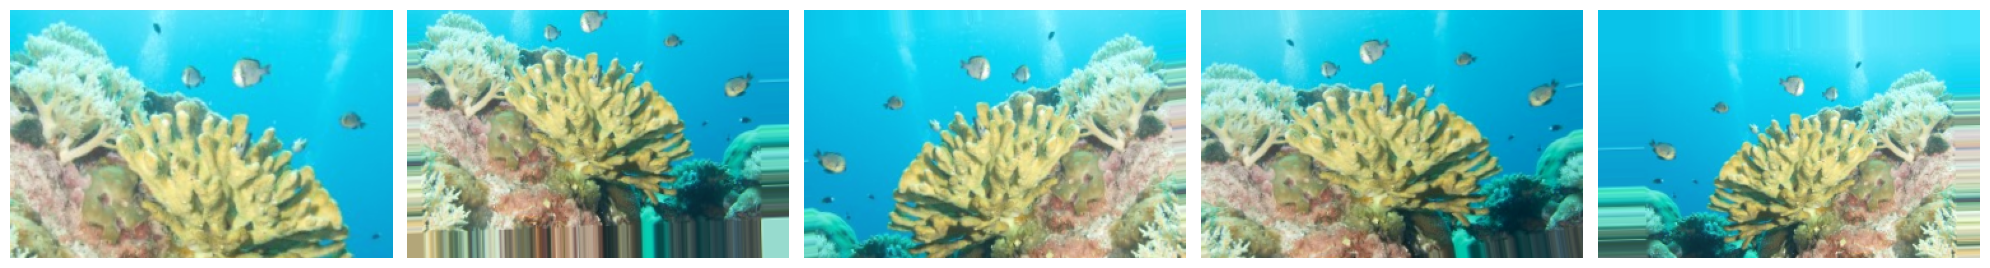

In [7]:
aug_im = [next(train_gen.flow(image))[0].astype(np.uint8) for i in range(5)]
plotImages(aug_im)

Defining the model architecture using Sequential API of Keras:

In [56]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,MaxPooling2D, Dropout

cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(224,224,3)))
cnn_model.add(MaxPooling2D((3,3)))
cnn_model.add(Conv2D(64, kernel_size=3, activation='relu'))
cnn_model.add(MaxPooling2D((3,3)))
cnn_model.add(Conv2D(128, kernel_size=3, activation='relu'))
cnn_model.add(MaxPooling2D((3,3)))
cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(2, activation='sigmoid'))

In [57]:
cnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 22, 22, 128)       73856     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 7, 7, 128)       

Visualizing the Model using visualkeras:

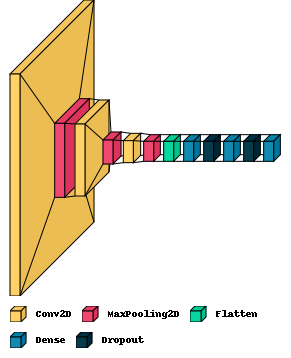

In [58]:
import visualkeras
visualkeras.layered_view(cnn_model, legend=True, scale_xy=1, scale_z=1, max_z=10) 

Model compilation and training:

In [60]:
cnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [61]:
train = cnn_model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=50)

Epoch 1/50
32/32 [==============================] - 18s 465ms/step - loss: 5.7558 - accuracy: 0.5848 - val_loss: 1.1277 - val_accuracy: 0.6774
Epoch 2/50
32/32 [==============================] - 15s 467ms/step - loss: 1.7113 - accuracy: 0.6181 - val_loss: 1.0247 - val_accuracy: 0.6452
Epoch 3/50
32/32 [==============================] - 16s 495ms/step - loss: 1.3513 - accuracy: 0.6292 - val_loss: 0.8295 - val_accuracy: 0.6237
Epoch 4/50
32/32 [==============================] - 15s 476ms/step - loss: 0.9055 - accuracy: 0.6609 - val_loss: 0.7446 - val_accuracy: 0.6559
Epoch 5/50
32/32 [==============================] - 15s 451ms/step - loss: 0.7495 - accuracy: 0.6719 - val_loss: 0.6843 - val_accuracy: 0.6774
Epoch 6/50
32/32 [==============================] - 15s 476ms/step - loss: 0.6497 - accuracy: 0.6989 - val_loss: 0.7989 - val_accuracy: 0.6129
Epoch 7/50
32/32 [==============================] - 16s 519ms/step - loss: 0.6579 - accuracy: 0.6973 - val_loss: 0.7098 - val_accuracy: 0.6129

Saving the weights in '.h5' format:

In [62]:
cnn_model.save_weights('./weights.h5')

Visualizing training and validation loss vs epochs:

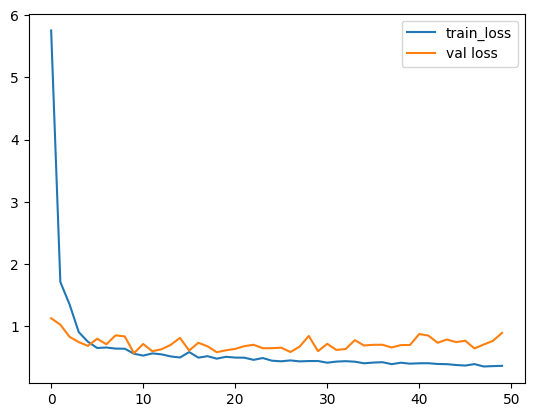

In [63]:
plt.plot(train.history['loss'],label = 'train_loss')
plt.plot(train.history['val_loss'],label = 'val loss')
plt.legend()
plt.show()

Evaluation on test data:

In [64]:
test_batches.class_indices

{'bleached_corals': 0, 'healthy_corals': 1}

In [65]:
test_labels = test_batches.classes

In [66]:
preds = cnn_model.predict(test_batches)

10/10 [==============================] - 1s 90ms/step


<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

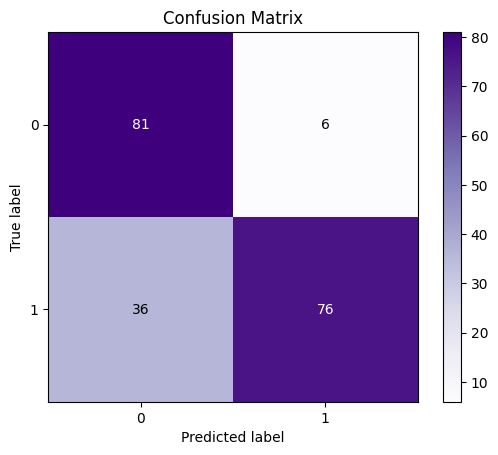

In [67]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(test_labels, preds.argmax(axis=1),normalize=False,title="Confusion Matrix",cmap="Purples",)

In [68]:
from sklearn.metrics import classification_report

print('\nClassification Report : ')
print(classification_report(test_labels, preds.argmax(axis=1)))


Classification Report : 
              precision    recall  f1-score   support

           0       0.69      0.93      0.79        87
           1       0.93      0.68      0.78       112

    accuracy                           0.79       199
   macro avg       0.81      0.80      0.79       199
weighted avg       0.82      0.79      0.79       199



# Transfer Learning

In [8]:
from keras.applications import VGG16
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
vgg16.summary()

58889256/58889256 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [9]:
x = vgg16.layers[-1].output
x = tf.keras.layers.Flatten()(x)
output = Dense(units=2, activation='sigmoid')(x)
model = Model(inputs=vgg16.input, outputs=output)
for layer in model.layers[:-8]:
    layer.trainable = False
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

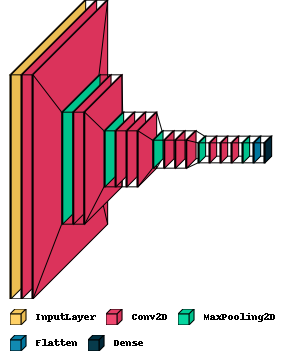

In [10]:
import visualkeras
visualkeras.layered_view(model, legend=True, scale_xy=1, scale_z=0.25, max_z=1) 

In [11]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=40
)

Epoch 1/40
32/32 [==============================] - 101s 3s/step - loss: 1.9452 - accuracy: 0.6101 - val_loss: 0.7953 - val_accuracy: 0.5914
Epoch 2/40
32/32 [==============================] - 111s 3s/step - loss: 0.6583 - accuracy: 0.6450 - val_loss: 0.6680 - val_accuracy: 0.6022
Epoch 3/40
32/32 [==============================] - 109s 3s/step - loss: 0.5616 - accuracy: 0.7116 - val_loss: 0.6612 - val_accuracy: 0.6237
Epoch 4/40
32/32 [==============================] - 111s 3s/step - loss: 0.5367 - accuracy: 0.7353 - val_loss: 0.8481 - val_accuracy: 0.6022
Epoch 5/40
32/32 [==============================] - 112s 3s/step - loss: 0.4727 - accuracy: 0.7702 - val_loss: 0.6254 - val_accuracy: 0.6344
Epoch 6/40
32/32 [==============================] - 111s 3s/step - loss: 0.4348 - accuracy: 0.7892 - val_loss: 0.7118 - val_accuracy: 0.6559
Epoch 7/40
32/32 [==============================] - 111s 3s/step - loss: 0.4414 - accuracy: 0.7876 - val_loss: 0.5770 - val_accuracy: 0.7097
Epoch 8/40
32

In [13]:
model.save_weights('./weights2.h5')

Plots of Training and Validation Accuracy against epochs

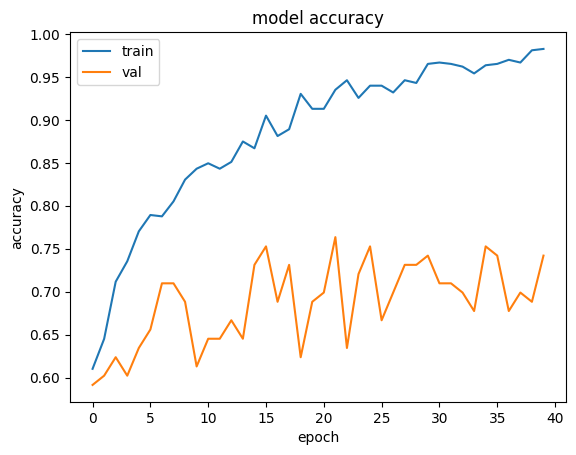

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
test_labels = test_batches.classes

In [19]:
preds = model.predict(test_batches)

10/10 [==============================] - 26s 2s/step


<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

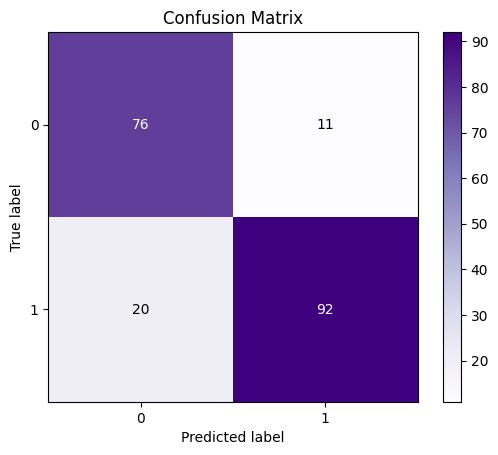

In [23]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(test_labels, preds.argmax(axis=1),normalize=False,title="Confusion Matrix",cmap="Purples",)

In [24]:
from sklearn.metrics import classification_report

print('\nClassification Report : ')
print(classification_report(test_labels, preds.argmax(axis=1)))


Classification Report : 
              precision    recall  f1-score   support

           0       0.79      0.87      0.83        87
           1       0.89      0.82      0.86       112

    accuracy                           0.84       199
   macro avg       0.84      0.85      0.84       199
weighted avg       0.85      0.84      0.84       199



## References:
### Tensorflow documentation:
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator